### Notebook Generating Lora Training Results

This notebook generates the main figures (Fig 6) for Section 4 in The paper "Where does In-context Learning Happen".

https://openreview.net/pdf?id=LLuSjg59an

The results can be obtained by running the baselines and the experiments for different models (GPTN2.7B, Bloom3B, Llama3.1-8B, Llama3.1-8B-Instruct, Starcoder2-7B) and for different task (machine_translation, code_gen). All language directions in FLORES are available for Machine Translation (en-fr, fr-en, en-pt, pt-en), while code_gen currently only supports en-py.

`$>bin/batch_submit_lora_train.sh` 


In [1]:
#%cd $HOME/projects/where_does_icl_happen
%cd /workspace/where_does_in-context-learning_happen_in_LLMs

/workspace/where_does_in-context-learning_happen_in_LLMs


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install seaborn > /dev/null 2>&1
!pip install omegaconf > /dev/null 2>&1

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

import json
import seaborn
sns.set_style('whitegrid')

from omegaconf import OmegaConf
import pandas as pd
import numpy as np
import argparse
import os

rd = lambda x: np.around(x, 2)

### Load Default args for Lora Training

In [5]:

cfp = OmegaConf.load(f"configs/file_paths/lora.yaml")
model_cf = OmegaConf.load(f'configs/model/default.yaml')
data_cf = OmegaConf.load('configs/data/default.yaml')
format_cf = OmegaConf.load('configs/format/instr_none_QA.yaml')
generator_cf = OmegaConf.load('configs/generator/default.yaml')
training_cf = OmegaConf.load('configs/training/default.yaml')
prompt_cf = OmegaConf.load('configs/prompt_select/random.yaml')

args = OmegaConf.merge(model_cf, data_cf, format_cf, generator_cf, training_cf, prompt_cf)
args.seed = 0
args.sample_prompts.nprompts = nprompts = 1

#### Load specific args for exp = mask_context_from

In [6]:

models = ['Llama-3.1-8B', 'Llama-3.1-8B-Instruct']

domain = "machine_translation" #"code_gen" # "translation"

if domain == "code_gen":
    instrs = ['instr_code_gen', 'instr_none_QA']
    args.data.trainset = "MBPP"
    args.data.testset = "HEVAL"
    args.data.direction = "en-py"
    conditions = [('instr_none_QA', nprompts, False, True, False), 
                  ("instr_code_gen", nprompts, True, True, False),
                  ("instr_code_gen", nprompts, False, True, False),
                  ("instr_code_gen", nprompts, False, False, True),
                  ("instr_code_gen", nprompts, True, True, True)]
    y='pass@1'
else:
    args.data.trainset = "FLORES"
    args.data.testset = "FLORES"
    args.data.direction = "en-fr"
    conditions = ['lora']

    y='bleu'


### Load data into the DataFrame for Plotting|

In [7]:
model_layers = {"gptn125M":12,
                "gptn2.7B":32, 
                "bloom3b":30, 
                "llama7b": 32, 
                "llama7b-chat":32,
                "Llama-3.1-8B-Instruct":32,
                "Llama-3.1-8B": 32,
                "starcoder2-3B":32, 
                "starcoder2-7B":32}

def get_df(cfp, args):
    df = []
    nlayers = model_layers[args.model.model_size]

    for j in range(nlayers):
        for s in range(2):
            for trainsize in [400, 800]:
                args.train_size = trainsize
                args.model.train_layer = j
                args.seed = s
                fn = cfp['res_fn'].format(**args) # + ".temp"
                if not os.path.exists(fn):
                    continue
        
                with open(fn, 'r') as f:
                    data = json.load(f)
    
                    if type(data) == list:
                        data = data[0]
    
                data_ = {"layer": j+1, "seed": s, "model": args.model.model_size, 'trainsize': trainsize,
                        "direction": args.data.direction}
                data.update(data_)
                df.append(data)
                
    df = pd.DataFrame(df)
    return df 


In [8]:
all_df = []
i = 0
for model in models:
    args.model.model_size = model
    df = get_df(cfp, args)
    all_df.append(df)
            
all_df = pd.DataFrame(pd.concat(all_df))
all_df = all_df.drop_duplicates()
print(len(all_df))

175


### Preparing to plot

0 Llama-3.1-8B
1 Llama-3.1-8B-Instruct


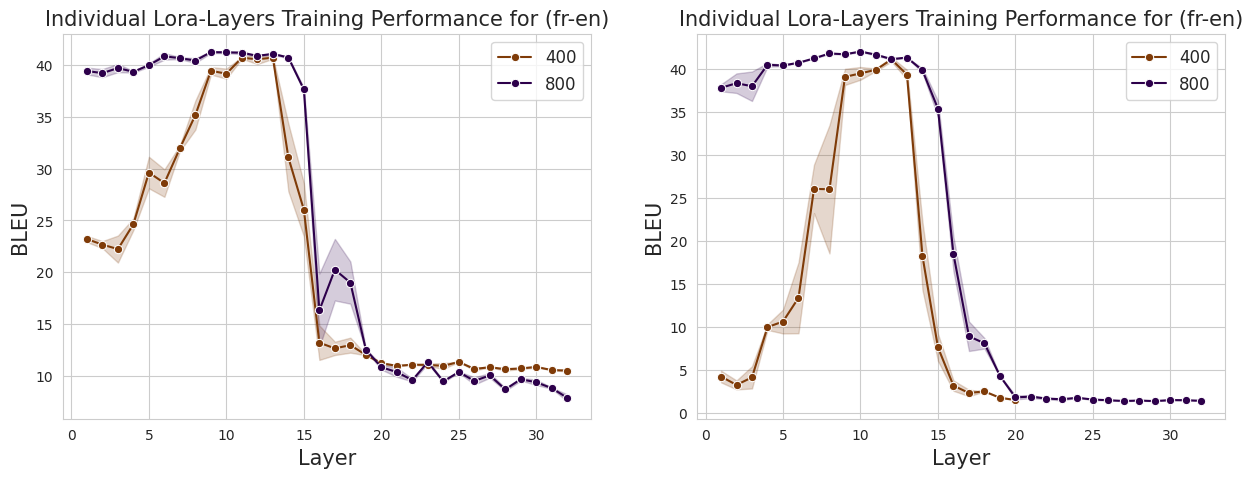

In [13]:
figs, axs = plt.subplots(1,len(models), figsize=(15, 5))

for i, model in enumerate(models):
    print(i, model)
    sns.lineplot(ax=axs[i], data=all_df[all_df['model']==model], x="layer", hue="trainsize", y=y, marker="o", palette="PuOr")
    axs[i].set_ylabel(y.upper(), fontsize=15)
    axs[i].set_xlabel('Layer', fontsize=15)
    axs[i].set_title(f"Individual Lora-Layers Training Performance for ({args.data.direction})", fontsize=15)
    axs[i].legend(fontsize=12)

plt.show()

Performance of models ((LLAMA3.1-8B and LLAMA3.1-8B-INSTRUCT for en↔fr)
trained with single LoRA layer, where each point on the x-axis reflects a single trained LoRA layer.
The LoRA layer was trained without instructions, and with causal LM cross-entropy loss over next
token prediction of parallel translation sentences. 400 and 800 refer to the size of the training set.
The layers which are most amenable to lightweight fine-tuning occur in the earlier layers before the
"task recognition" point.